In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

c:\Users\PARASURAM\anaconda3\envs\torchenv\lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\PARASURAM\anaconda3\envs\torchenv\lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\PARASURAM\anaconda3\envs\torchenv\lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/resource_handle.proto. Please upd

In [2]:
df = pd.read_csv('Data/Real-Data/Real_Combine.csv')

# Display basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nDataset Info:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())

Dataset Shape: (731, 9)

First 5 rows:
      T    TM   Tm     SLP     H   VV    V    VM      PM 2.5
0   7.4   9.8  4.8  1017.6  93.0  0.5  4.3   9.4  219.720833
1   7.8  12.7  4.4  1018.5  87.0  0.6  4.4  11.1  182.187500
2   6.7  13.4  2.4  1019.4  82.0  0.6  4.8  11.1  154.037500
3   8.6  15.5  3.3  1018.7  72.0  0.8  8.1  20.6  223.208333
4  12.4  20.9  4.4  1017.3  61.0  1.3  8.7  22.2  200.645833

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   T       731 non-null    float64
 1   TM      731 non-null    float64
 2   Tm      731 non-null    float64
 3   SLP     731 non-null    float64
 4   H       731 non-null    float64
 5   VV      731 non-null    float64
 6   V       731 non-null    float64
 7   VM      731 non-null    float64
 8   PM 2.5  730 non-null    float64
dtypes: float64(9)
memory usage: 51.5 KB
None

Missing Values:
T     

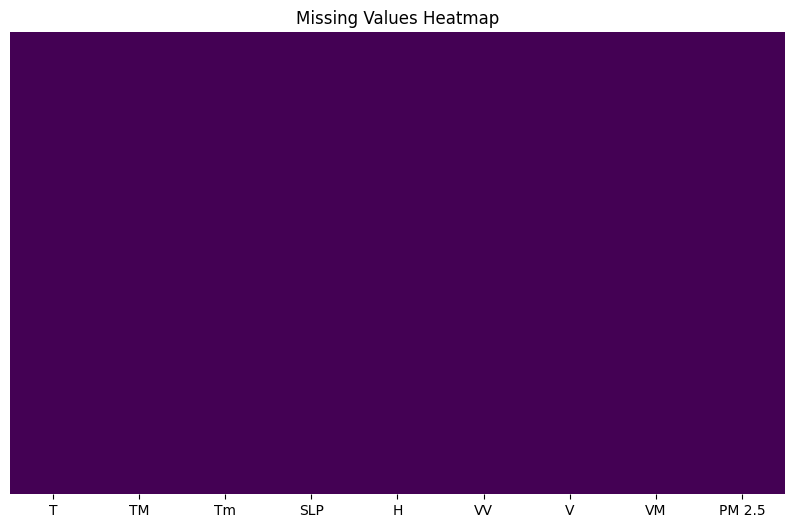

In [3]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

In [4]:
df = df.dropna()
print(f"Dataset shape after dropping null values: {df.shape}")

# Separate features and target
X = df.iloc[:, :-1]  # Independent features
y = df.iloc[:, -1]   # Dependent feature (PM 2.5)

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

Dataset shape after dropping null values: (730, 9)
Features shape: (730, 8)
Target shape: (730,)


In [5]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Scale features
X_scaled = scaler_X.fit_transform(X)
# Scale target
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

print("Feature scaling completed")

Feature scaling completed


In [6]:
def create_sequences(X, y, time_steps=1):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:(i + time_steps)])
        y_seq.append(y[i + time_steps])
    return np.array(X_seq), np.array(y_seq)

In [7]:
TIME_STEPS = 3
X_sequences, y_sequences = create_sequences(X_scaled, y_scaled, TIME_STEPS)

print(f"Sequences shape: {X_sequences.shape}")
print(f"Target sequences shape: {y_sequences.shape}")

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_sequences, y_sequences, test_size=0.2, random_state=42, shuffle=False
)

print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Testing set shape: {X_test.shape}, {y_test.shape}")

Sequences shape: (727, 3, 8)
Target sequences shape: (727,)
Training set shape: (581, 3, 8), (581,)
Testing set shape: (146, 3, 8), (146,)


In [8]:
def create_lstm_model(input_shape):
    model = Sequential()
    
    # First LSTM layer
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    
    # Second LSTM layer
    model.add(LSTM(50, return_sequences=True))
    model.add(Dropout(0.2))
    
    # Third LSTM layer
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    
    # Dense layers
    model.add(Dense(25, activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(1))  # Output layer
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss='mse', 
                  metrics=['mae'])
    
    return model

In [9]:
model = create_lstm_model((X_train.shape[1], X_train.shape[2]))
print("LSTM Model Summary:")
model.summary()

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train the model
print("Training LSTM model...")
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=100,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    verbose=1,
    shuffle=False
)

LSTM Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 3, 50)          │        11,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 3, 50)          │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,501 (208.99 KB)

 Trainable params: 53,501 (208.99 KB)

 Non-trainable params: 0 (0.00 B)

Training LSTM model...
Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.9018 - mae: 0.7605 - val_loss: 0.8844 - val_mae: 0.7546
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6417 - mae: 0.6224 - val_loss: 0.5872 - val_mae: 0.5865
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5239 - mae: 0.5363 - val_loss: 0.6319 - val_mae: 0.5720
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5069 - mae: 0.5247 - val_loss: 0.6293 - val_mae: 0.5648
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4944 - mae: 0.5162 - val_loss: 0.6137 - val_mae: 0.5519
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5094 - mae: 0.5101 - val_loss: 0.6618 - val_mae: 0.5731
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4653 - mae: 0.4948 - val_loss: 0.5981 - val_mae: 0.5495
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4804 - mae: 0.5034 - val_loss: 0.6235 - val_mae: 0.5626
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0

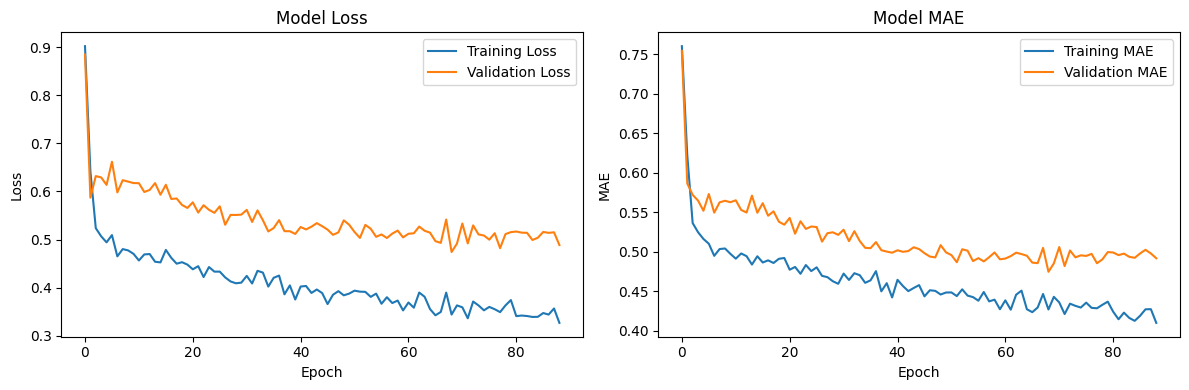

In [10]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
y_pred_scaled = model.predict(X_test)

# Inverse transform the predictions and actual values
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Calculate evaluation metrics
mse = mean_squared_error(y_test_original, y_pred)
mae = mean_absolute_error(y_test_original, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_original, y_pred)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


In [12]:
print("\n" + "="*50)
print("LSTM MODEL EVALUATION")
print("="*50)
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²) Score: {r2:.4f}")


LSTM MODEL EVALUATION
Mean Squared Error (MSE): 3229.7667
Root Mean Squared Error (RMSE): 56.8310
Mean Absolute Error (MAE): 39.1602
R-squared (R²) Score: 0.5580


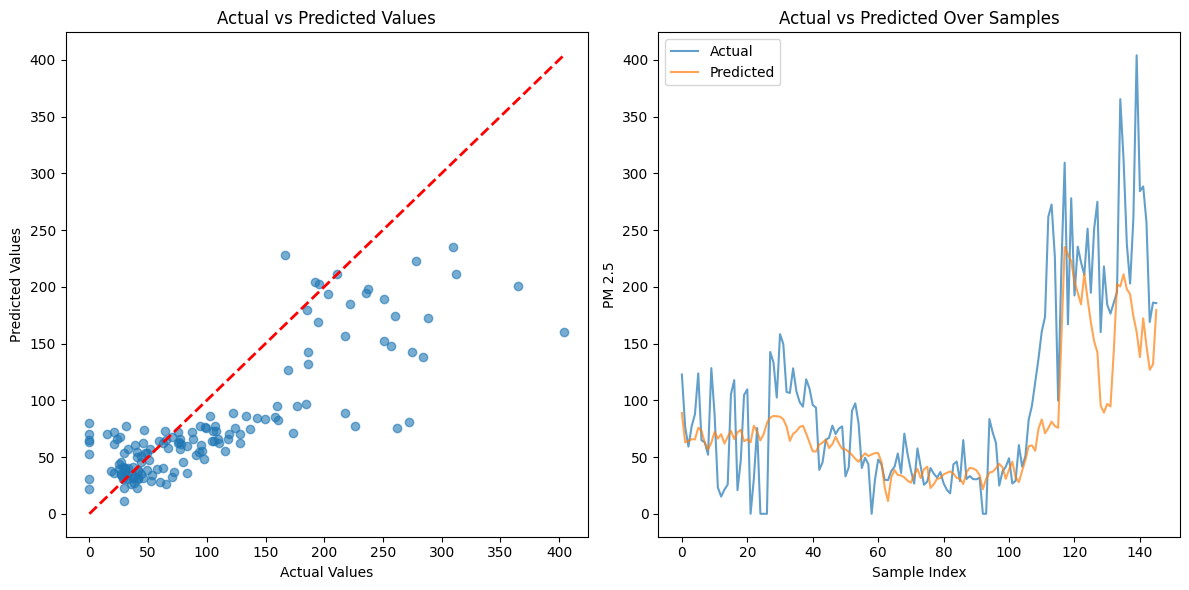

In [13]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test_original, y_pred, alpha=0.6)
plt.plot([y_test_original.min(), y_test_original.max()], 
         [y_test_original.min(), y_test_original.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')

plt.subplot(1, 2, 2)
plt.plot(y_test_original, label='Actual', alpha=0.7)
plt.plot(y_pred, label='Predicted', alpha=0.7)
plt.xlabel('Sample Index')
plt.ylabel('PM 2.5')
plt.title('Actual vs Predicted Over Samples')
plt.legend()

plt.tight_layout()
plt.show()

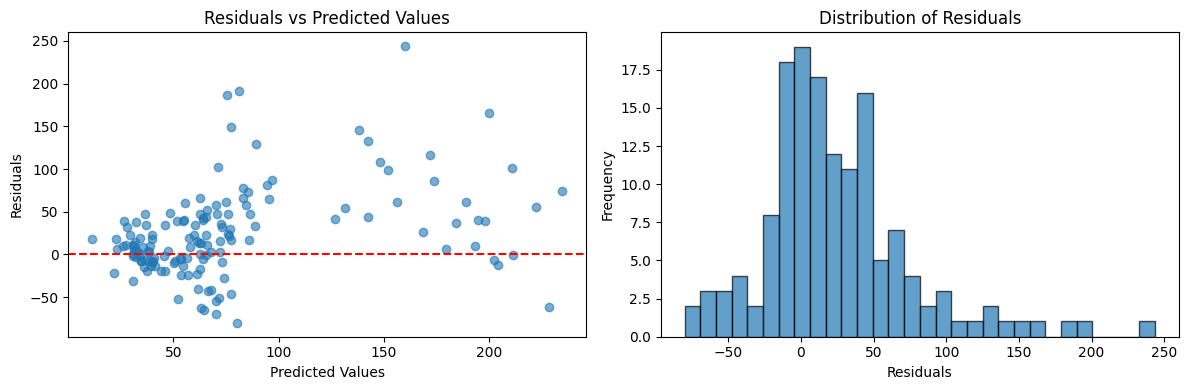

In [14]:
residuals = y_test_original.flatten() - y_pred.flatten()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')

plt.subplot(1, 2, 2)
plt.hist(residuals, bins=30, alpha=0.7, edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')

plt.tight_layout()
plt.show()